### This notebook simulates camera movie data
Note that this simulation uses photon counting mode but has commented out options for analog mode.  It differs from sim_movie.ipynb in that it confines the molecules to a subregion and the molecules bleach with a poisson probability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysimfcs_utils as simutils
import analysis_utils as autils
from tqdm.notebook import tqdm
import pandas as pd
import tifffile

In [2]:
#each species is described by number of particles, diffusion coefficient, and a brightness array (length 2?)
simspecies=[{'N':2000,'D':10.0,'B':[100000.0]}]
#simspecies=[{'N':2000,'D':1.0,'B':[100000.0,100000.0]},
#           {'N':2000,'D':1.0,'B':[100000.0,0.0]}]

In [3]:
#the simulation settings are boxsize (microns), boxpixels, w0 (2 sigma psf)
#zratio (z0/w0), nframes, frametime (us), background (array of cps), dims (active dimensions)
#mode--point, raster_line, raster_image, and image
simsettings={'boxsize':6.4,'boxpixels':128,'w0':0.17,'zratio':5,'nframes':256,
             'frametime':1000.0,'background':[100.0],'dims':[True,True,True],
             'mode':'image','boundarytype':'periodic','noisemode':'poisson'}

In [4]:
ssimsettings=simutils.scaleSimSettings(simsettings)
ssimspecies=simutils.scaleSimSpecies(simsettings,simspecies)

In [5]:
ssimsettings

{'boxsize': 6.4,
 'boxpixels': 128,
 'w0': 3.4,
 'zratio': 5,
 'nframes': 256,
 'frametime': 1000.0,
 'background': [0.1],
 'dims': [True, True, True],
 'mode': 'image',
 'boundarytype': 'periodic',
 'noisemode': 'poisson'}

In [6]:
ssimspecies

[{'N': 2000, 'D': 3.999999999999999, 'B': [100.0]}]

In [7]:
simstack=simutils.runConfinedBleachingSim(ssimsettings,ssimspecies,bleachrate=5.0)

bleachframeprob 0.00498752080731768


  0%|          | 0/256 [00:00<?, ?it/s]

In [8]:
simstack.shape

(256, 1, 128, 128)

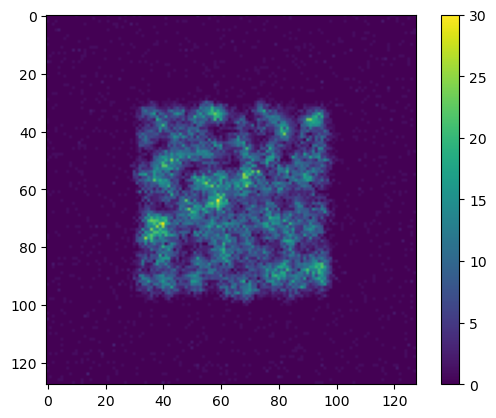

In [9]:
plt.imshow(simstack[0,0])
plt.colorbar()

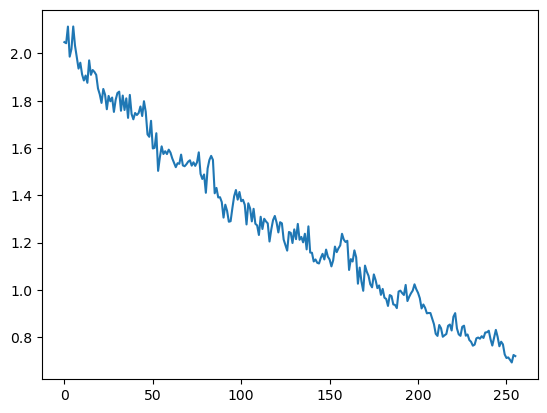

In [10]:
plt.plot([simframe.mean() for simframe in simstack])

In [11]:
tifffile.imwrite('movie_confined_bleaching.tif',simstack.astype(float))

In [12]:
nchan=len(simspecies)
corrstack=[]
for i in range(nchan):
    corr=np.array([autils.autocorr2d(simimg) for simimg in simstack[i]]).mean(axis=0)
    corr=autils.avgquadrants(corr)
    midx,midy=corr.shape[0]//2,corr.shape[1]//2
    #set the middle pixel to the average from either side
    corr[midy,midx]=0.5*(corr[midy,midx+1]+corr[midy,midx-1])
    corrstack.append(corr)

In [13]:
ccorr=np.array([autils.crosscorr2d(simstack[0][i],simstack[1][i]) for i in range(len(simstack[0]))]).mean(axis=0)
ccorr=autils.avgquadrants(ccorr)
corrstack.append(ccorr)

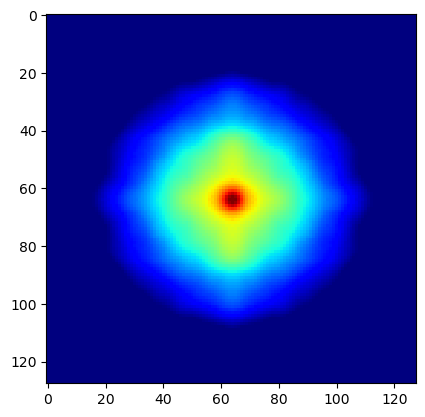

In [14]:
maxcorr=max([img.max() for img in corrstack])
plt.imshow(corrstack[0],interpolation='none',vmin=0,vmax=maxcorr,cmap='jet')

Text(0, 0.5, 'G(pos)')

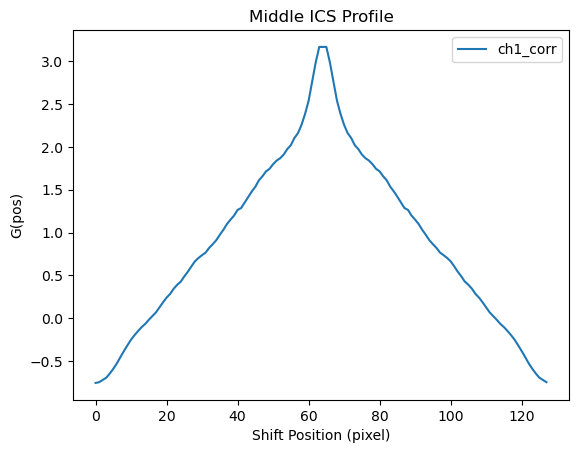

In [15]:
midpos=simsettings['boxpixels']//2
plt.plot(corrstack[0][midpos])
plt.title('Middle ICS Profile')
plt.legend(['ch1_corr'])
plt.xlabel('Shift Position (pixel)')
plt.ylabel('G(pos)')